In [1]:
# Using earthaccess access pattern for direct access of cloud-hosted 
# MEaSUREs BedMachine Antarctica bed/ice topography dataset
# Calculates hydropotential fields, flow paths and delineates subglacial water drainage basins
# 
# Code  written to run on CryoCloud cloud-computing JupyterHub
# Learn more: https://cryointhecloud.com/
# 
# Written 2023-11-15 by Wilson Sauthoff (wsauthoff.github.io)

In [2]:
# Goal: get figure similar to Figs 3, 4 of Willis and others, 2016, Annals of Glaciology (https://doi.org/10.1017/aog.2016.15)

# Setup computing environment

In [3]:
%pip install pysheds

  Using cached pysheds-0.4-py3-none-any.whl
  Using cached looseversion-1.3.0-py2.py3-none-any.whl.metadata (4.6 kB)
Using cached looseversion-1.3.0-py2.py3-none-any.whl (8.2 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import libraries
import cv2
import earthaccess
import geopandas as gpd
from IPython.display import clear_output
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pysheds.grid import Grid
from shapely.geometry import LineString, mapping, MultiPoint, Point, Polygon
import xarray as xr

# Magic functions
%matplotlib widget

# Define data directories dependent on home environment
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/my_repos/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/'

# Define utility func's
def multipoint_to_centroid(geometry):
    '''
    Function to convert multipoint to its centroid
    '''
    if isinstance(geometry, MultiPoint):
        # Calculate the centroid of the multipoint geometry
        return geometry.centroid
    else:
        # Return the original geometry if it's not a MultiPoint
        return geometry

def apply_affine_to_polygon(polygon, affine):
    '''
    Function to apply affine transformation to polygon vertices
    '''
    # Define a function that applies the affine transformation to a point
    def transform_point(point):
        # Apply affine transformation: affine * (col, row)
        return affine * (point[0], point[1])

    # Apply the transformation to all exterior points of the polygon
    exterior_coords = [transform_point((x, y)) for x, y in np.array(polygon.exterior.coords)]
    
    # If the polygon has interior holes, transform their coordinates as well
    interior_coords = [[transform_point((x, y)) for x, y in np.array(interior.coords)] for interior in polygon.interiors]
    
    # Create a new polygon with the transformed coordinates
    return Polygon(exterior_coords, holes=interior_coords)

# Import datasets

In [6]:
# Import subglacial lake outlines 
stationary_lakes_gdf = gpd.read_file('/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/static_lakes_gdf.geojson')

In [7]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [8]:
# Find cloud-hosted BedMachine Antarctica bed/ice geometry dataset, Version 3
# DOI from https://nsidc.org/data/NSIDC-0754/versions/1
results = earthaccess.search_data(
    doi='10.5067/FPSU0V1MWUB6',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 1


In [9]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

Opening 1 granules, approx size: 0.79 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0756.003/1970.01.01/BedMachineAntarctica-v3.nc>]

In [10]:
# Print file name to ensure expected dataset
print(files[0])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0756.003/1970.01.01/BedMachineAntarctica-v3.nc>


In [11]:
# Open file into xarray dataset
bedmachine = xr.open_dataset(files[0])
bedmachine

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y          (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    mapping    |S1 1B ...
    mask       (y, x) int8 178MB ...
    firn       (y, x) float32 711MB ...
    surface    (y, x) float32 711MB ...
    thickness  (y, x) float32 711MB ...
    bed        (y, x) float32 711MB ...
    errbed     (y, x) float32 711MB ...
    source     (y, x) int8 178MB ...
    dataid     (y, x) int8 178MB ...
    geoid      (y, x) int16 356MB ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [12]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'surface', 'thickness', 'bed']

variables_to_drop = [var for var in bedmachine.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
bedmachine = bedmachine.drop_vars(variables_to_drop)
bedmachine

<xarray.Dataset> Size: 2GB
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y          (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    surface    (y, x) float32 711MB ...
    thickness  (y, x) float32 711MB ...
    bed        (y, x) float32 711MB ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [13]:
# Use BedMachine bed topography for Zbed; static BedMachine surface topogrpahy for static Zsurf
rho_water = 997
rho_ice = 917
bedmachine = bedmachine.assign(stationary_hydropotential_kPa = (9.8 * ((rho_ice*bedmachine['surface']) + (rho_water-rho_ice)*bedmachine['bed']))/1e3)

# Display xarray.Dataset metadata
bedmachine

<xarray.Dataset> Size: 3GB
Dimensions:                        (x: 13333, y: 13333)
Coordinates:
  * x                              (x) int32 53kB -3333000 -3332500 ... 3333000
  * y                              (y) int32 53kB 3333000 3332500 ... -3333000
Data variables:
    surface                        (y, x) float32 711MB 0.0 0.0 0.0 ... 0.0 0.0
    thickness                      (y, x) float32 711MB ...
    bed                            (y, x) float32 711MB -5.916e+03 ... -3.664...
    stationary_hydropotential_kPa  (y, x) float32 711MB -4.638e+03 ... -2.873...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [14]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [15]:
# Clip BedMachine to grounding line to limit drainage basin delineation to only below grounded ice
# Add 1000 m buffer to grounding line so that branches extend outward from grounding line 
# so that we can find the intersection points of the branches and the grounding line for basin delineation
bedmachine.rio.write_crs("epsg:3031", inplace=True)
# bedmachine_clipped = bedmachine.rio.clip(Scripps_landice.geometry.values.buffer(20000), Scripps_landice.crs)

<xarray.Dataset> Size: 3GB
Dimensions:                        (x: 13333, y: 13333)
Coordinates:
  * x                              (x) int32 53kB -3333000 -3332500 ... 3333000
  * y                              (y) int32 53kB 3333000 3332500 ... -3333000
    mapping                        int64 8B 0
Data variables:
    surface                        (y, x) float32 711MB 0.0 0.0 0.0 ... 0.0 0.0
    thickness                      (y, x) float32 711MB ...
    bed                            (y, x) float32 711MB -5.916e+03 ... -3.664...
    stationary_hydropotential_kPa  (y, x) float32 711MB -4.638e+03 ... -2.873...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [16]:
# # Delete intermediary file to reduce memory usage
# del bedmachine

In [17]:
# MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar V002 (IMBIE ice drainage basins)
# https://doi.org/10.5067/AXE4121732AD
# https://nsidc.org/sites/default/files/nsidc-0709-v002-userguide.pdf
IMBIE_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_IMBIE_Antarctica_v02.shp')
refined_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_Antarctica_v02.shp')
# ice_boundaries = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/IceBoundaries_Antarctica_v02.shp')
# grounded_ice_boundaries = ice_boundaries[ice_boundaries["TYPE"]=='GR']

# Analysis

## Stationary subglacial flow paths

In [18]:
# Ideas for how to tackle this:
# Use scikit contour to make polygon around catchment (do not trim grid to catchment first)
# Trying making for loop of pour points where flow is predicted to cross grounding line (GL) for watershed delineation
# https://github.com/mdbartos/pysheds/issues/64#issuecomment-462951248

# Additional blog resource
# https://www.meteomatics.com/en/blog/watershed-delineation-with-pysheds/

# This notebook may be a solution for the following stackexchange questions:
# https://gis.stackexchange.com/questions/9237/methodology-for-creating-accurate-drainage-networks-and-catchments-from-high-r

# Perhaps you could write this into medium or substack post like this one but gets watershed boundary:
# https://medium.com/@ilmachairas/basin-delineation-on-python-5e9da00a3534

In [19]:
# Create temporary tif of hydropotential field
# Define array
# arr = bedmachine_clipped['stationary_hydropotential_kPa']
arr = bedmachine['stationary_hydropotential_kPa']

# Write CRS
arr3031 = arr.rio.write_crs("EPSG:3031")

# Specify the output raster file path
output_raster_path = 'temp_raster.tif'

# Convert xarray DataArray to raster and save it
arr3031.rio.to_raster(output_raster_path)

# Initialize a grid and DEM from a raster
grid = Grid.from_raster('temp_raster.tif')#, nodata=np.nan)
dem = grid.read_raster('temp_raster.tif')#, nodata=np.nan)

# Delete temp tif file
os.remove('temp_raster.tif')

# Fill pits in hydropotential DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in hydropotentialDEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in hydropotential DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify directional mapping for the type of routing algo you wish to use
# dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem)#, dirmap=dirmap)  # Don't specify dirmap to use default dirmap (not sure which this is - D-infinity? D-8?)

# Calculate flow accumulation
acc = grid.accumulation(fdir)#, dirmap=dirmap)

/srv/conda/envs/notebook/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


In [20]:
# # To extract river network, you can use a threshold on the flow accumulation
# threshold = 15000  # This value depends on your specific application
# branches = grid.extract_river_network(fdir, acc > threshold)#, dirmap=dirmap)

In [21]:
# Larger basins to debug method

# To extract river network, you can use a threshold on the flow accumulation
threshold = 10000  # This value depends on your specific application
branches = grid.extract_river_network(fdir, acc > threshold)#, dirmap=dirmap)

In [22]:
# Store
line_strings = []

for branch in branches['features']:
    line_coords = branch['geometry']['coordinates']
    line = LineString(line_coords)
    line_strings.append(line)

flow_paths_gdf = gpd.GeoDataFrame(geometry=line_strings)

In [23]:
# Set the CRS for gdf if it's not set
if flow_paths_gdf.crs is None:
    flow_paths_gdf.set_crs("EPSG:3031", inplace=True)

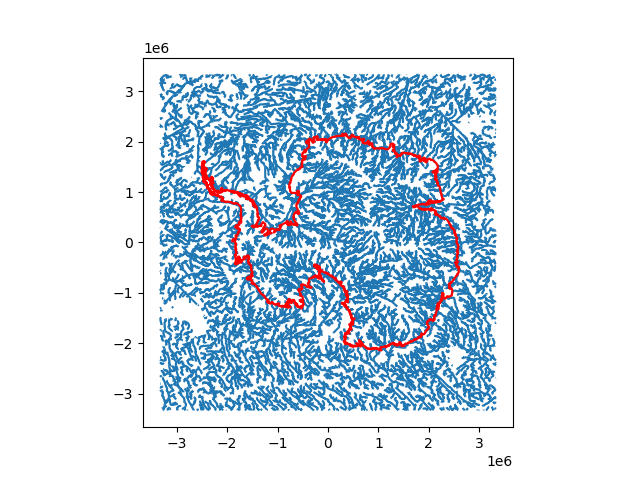

In [24]:
# Visualize 
fig, ax = plt.subplots()
flow_paths_gdf.plot(ax=ax)
Scripps_landice.boundary.plot(ax=ax, color='red')
plt.show()

## Grounding zone outlet points

In [27]:
# Finding intersections of the flow paths at the grounding line
# We will use these as "pour points" to delineate subglacial water drainage basins
intersections = flow_paths_gdf.intersection(Scripps_landice.boundary.unary_union)

# Many rows of intersections_gdf are LINESTRING EMPTY because the the flow path branch row in 
# flow_paths_gdf did not have an intersection with Scripps_landice grounding line,
# so filtering for 'Point' and 'MultiPoint' geometries, where an intersection was found
filtered_intersections = intersections[intersections.type.isin(['Point', 'MultiPoint'])]

# Converting the GeoSeries to a GeoDataFrame with 'geometry' as the geometry column name
intersections_gdf = gpd.GeoDataFrame(geometry=filtered_intersections, crs=flow_paths_gdf.crs)

# Delete intermediary geoseries for memory conservation
del filtered_intersections

In [28]:
# Ensure no loss of points/multipoints
print(len(intersections_gdf))
print(len(intersections_gdf[intersections_gdf.geometry.type.isin(['MultiPoint'])])
    + len(intersections_gdf[intersections_gdf.geometry.type.isin(['Point'])]))

282
282


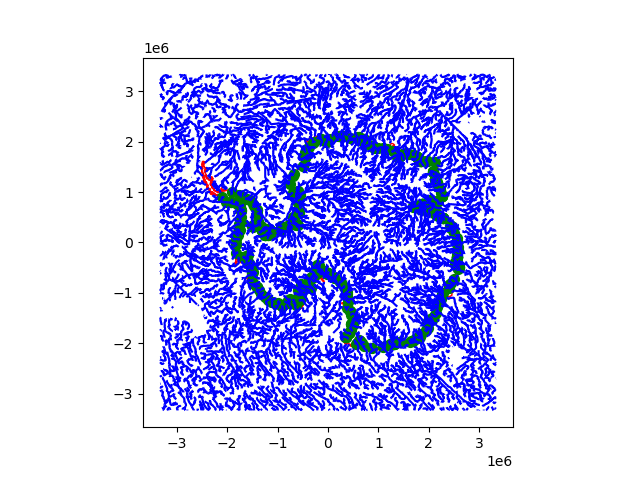

In [29]:
# Visualize 
fig, ax = plt.subplots()
flow_paths_gdf.plot(ax=ax, edgecolor='blue')
Scripps_landice.plot(ax=ax, color='none', edgecolor='red')
intersections_gdf.plot(ax=ax, color='green', markersize=50)
plt.show()

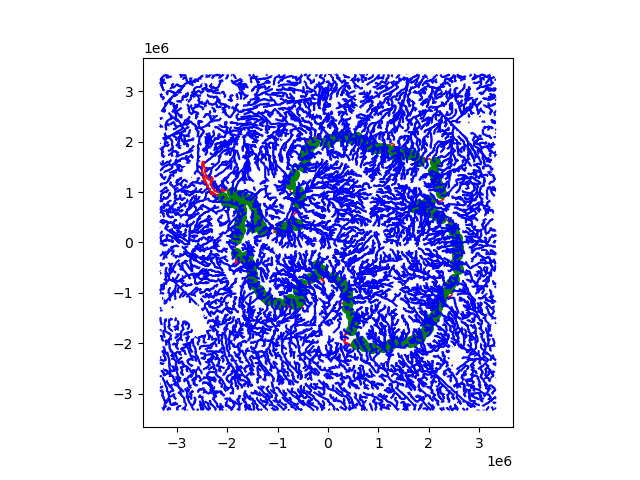

In [30]:
# Visualize 
fig, ax = plt.subplots()
flow_paths_gdf.plot(ax=ax, edgecolor='blue')
Scripps_landice.plot(ax=ax, color='none', edgecolor='red')
intersections_gdf[intersections_gdf.geometry.type.isin(['Point'])].plot(ax=ax, color='green', markersize=50)
plt.show()

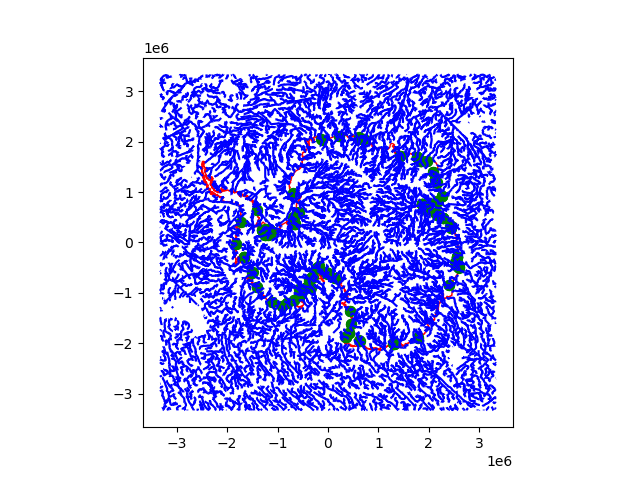

In [31]:
# Visualize 
fig, ax = plt.subplots()
flow_paths_gdf.plot(ax=ax, edgecolor='blue')
Scripps_landice.plot(ax=ax, color='none', edgecolor='red')
intersections_gdf[intersections_gdf.geometry.type.isin(['MultiPoint'])].plot(ax=ax, color='green', markersize=50)
plt.show()

In [32]:
# intersections_gdf contains mulipoints, which will not work for using a single pour point
# to delineate subglacial watershed, so we convert each multipoint geometry to its centroid point
intersections_gdf['geometry'] = intersections_gdf['geometry'].apply(multipoint_to_centroid)

# Print geodataframe length to ensure no multipoints/points were lost
print(len(intersections_gdf))

282


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [33]:
# Reset the index
intersections_gdf=intersections_gdf.reset_index()
intersections_gdf

,index,geometry
0,1526,POINT (221769.046 2113720.473)
1,1537,POINT (715357.622 2046228.750)
2,1557,POINT (-1281.029 2026281.029)
3,1590,POINT (293833.759 2120833.759)
4,1595,POINT (-270564.701 1992250.000)
...,...,...
277,7422,POINT (564093.283 -2005750.000)
278,7424,POINT (1315923.421 -2012267.762)
279,7428,POINT (1254250.000 -2010665.165)
280,7442,POINT (1084278.668 -2075221.332)


In [ ]:
# # Trying to do just on multipoint gdf because was moving or destorying some points

# # Function to convert multipoint to its centroid
# def multipoint_to_centroid(geometry):
#     if isinstance(geometry, MultiPoint):
#         # Calculate the centroid of the multipoint geometry
#         return geometry.centroid
#     else:
#         # Return the original geometry if it's not a MultiPoint
#         return geometry

# # Apply the function to each geometry in the GeoDataFrame
# intersections_multi_gdf['geometry'] = intersections_multi_gdf['geometry'].apply(multipoint_to_centroid)
# intersections_multi_gdf

In [ ]:
# # Concatenate
# intersections_gdf_combined = pd.concat([intersections_multi_gdf, intersections_point_gdf], ignore_index=True)

In [ ]:
# print(len(intersections_gdf))
# print(len(intersections_gdf_combined))

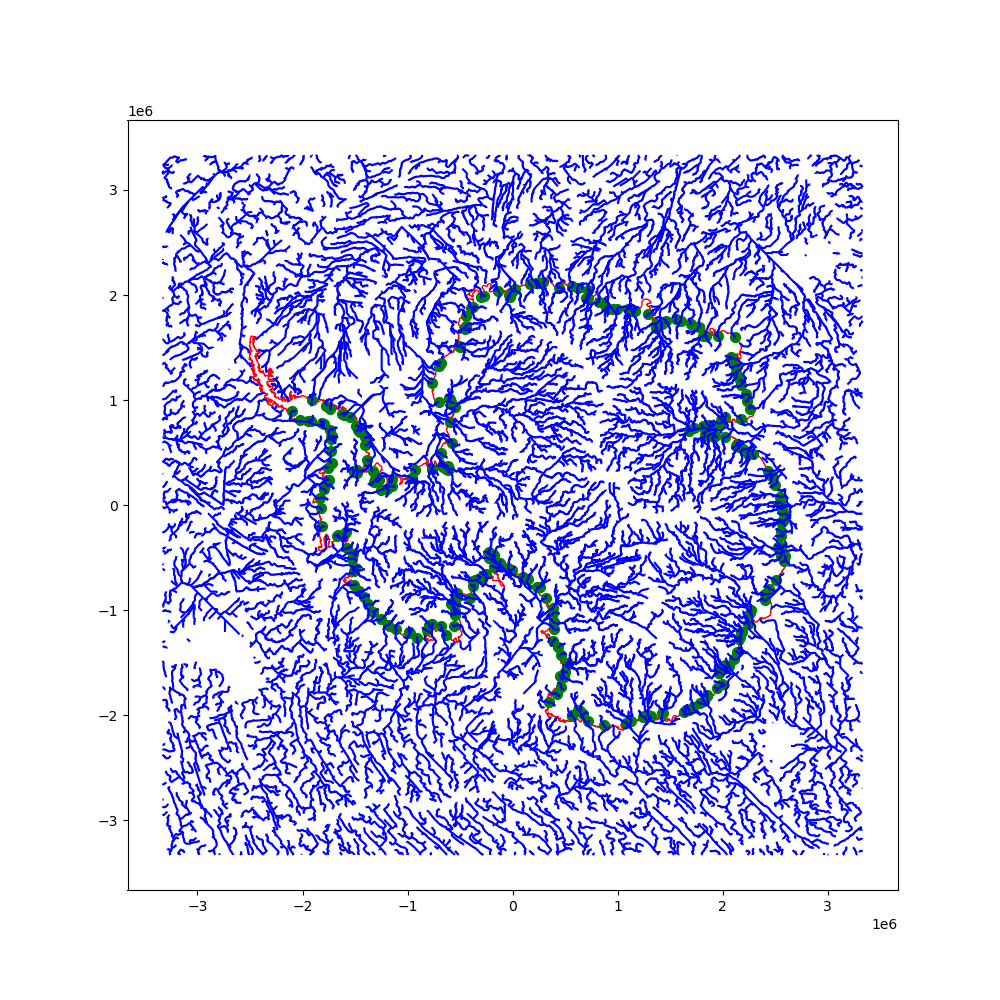

In [34]:
# Visualize 
fig, ax = plt.subplots(figsize=(10,10))
flow_paths_gdf.plot(ax=ax, edgecolor='blue')
Scripps_landice.plot(ax=ax, color='none', edgecolor='red')
# bedmachine['stationary_hydropotential_kPa'].plot(ax=ax, cmap='terrain')  # Slow to plot
intersections_gdf.plot(ax=ax, color='green', markersize=50)
plt.show()

## Stationary watershed delineation

In [ ]:
# Initialize a list to hold the transformed polygons for all points
watershed_polygons = []

# Store total for displaying for loop progess
total = len(intersections_gdf)

for idx, row in intersections_gdf.iterrows():

    # Display progress
    print(f'Processing watershed {idx} of {total}...')  # Display current index out of total
    
    # Extract x, y coords from points from geometry column and snap to mask 
    point = row.geometry
    x, y = point.x, point.y
    x_snap, y_snap = grid.snap_to_mask(acc > threshold, (x, y))
    
    # Delineate the catchment for the current point
    raster = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, #dirmap=dirmap, 
        xytype='coordinate')
    
    # Convert True/False to 0/255 and ensure the type is np.uint8 for cv2 contouring step
    raster = (raster > 0).astype(np.uint8) * 255
    
    # Find contours
    contours, hierarchy = cv2.findContours(raster, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Convert contours to polygons for the current point
    polygons = [Polygon(contour.reshape(-1, 2)) for contour in contours if len(contour) > 2]
    
    # if polygons:
    # Apply affine transformation to the largest polygon
    watershed_polygon = apply_affine_to_polygon(polygons[0], raster.affine)
    
    # Store the transformed polygon
    watershed_polygons.append(watershed_polygon)
    # else:
    #     # Handle cases where no polygon was found
    #     watershed_polygons.append(None)

    # Clear output of each loop
    clear_output(wait=True)

In [ ]:
# Convert to GeoDataFrame
watersheds_gdf = gpd.GeoDataFrame(geometry=watershed_polygons)

# Set the CRS for the GeoDataFrame
watersheds_gdf.set_crs(Scripps_landice.crs, inplace=True)

In [ ]:
# Check for invalid geometries
watersheds_gdf[~watersheds_gdf.is_valid]

In [ ]:
# Repair invalid geometries
watersheds_gdf.loc[~watersheds_gdf.is_valid, 'geometry'] = watersheds_gdf[~watersheds_gdf.is_valid].geometry.buffer(0)

# Check if there are still any invalid geometries
print(watersheds_gdf[~watersheds_gdf.is_valid])

In [ ]:
# Visualize
fig, ax = plt.subplots()

Scripps_landice.plot(ax=ax, color='white', edgecolor='red')
flow_paths_gdf.plot(ax=ax, edgecolor='lightblue')
lakes_gdf.plot(ax=ax, color='cyan')
watersheds_gdf.plot(ax=ax, color='none', edgecolor='blue')
intersections_gdf.plot(ax=ax, color='green', markersize=50)

# Iterate through the GeoDataFrame to annotate each polygon
# for idx, row in lakes_gdf.iterrows():
#     # Use the centroid of each polygon for the annotation location
#     centroid = row['geometry'].centroid
#     ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [ ]:
# Visualize
fig, ax = plt.subplots()
watersheds_gdf.plot(ax=ax, color='none', edgecolor='blue')
Scripps_landice.plot(ax=ax, color='white', edgecolor='red', alpha=0.75)
plt.show()

In [ ]:
# Some watershed polygons extend seaward of GL because of complex routing pathways
# that intersect the GL but then go seaward vs. inland (e.g., the peninsula on the
# Siple Coast), so will clip watershed_gdf to the GL so that the watersheds are all
# inland of the GL
clipped_watersheds_gdf = gpd.clip(watersheds_gdf, Scripps_landice)

In [ ]:
# Visualize
fig, ax = plt.subplots()
clipped_watersheds_gdf.plot(ax=ax, color='none', edgecolor='blue')
Scripps_landice.plot(ax=ax, color='white', edgecolor='red', alpha=0.75)
plt.show()

In [ ]:
# Export geodataframe to geojson for future use
clipped_watersheds_gdf.to_file('output/subglacial_watersheds.geojson', driver='GeoJSON')

In [ ]:
# Similarly clip flow paths and export
# Clip flow path branches to grounding line
clipped_flow_paths_gdf = gpd.clip(flow_paths_gdf, Scripps_landice)

In [ ]:
# Export geodataframe to geojson for future use
clipped_flow_paths_gdf.to_file('output/subglacial_flow_paths.geojson', driver='GeoJSON')

In [ ]:
# Import geojsons to geodataframes to ensure export worked properly
clipped_watersheds_gdf_readin = gpd.read_file('output/subglacial_watersheds.geojson')
clipped_flow_paths_gdf_readin = gpd.read_file('output/subglacial_flow_paths.geojson', driver='GeoJSON')

In [ ]:
# Visualize
fig, ax = plt.subplots(figsize=(5,5))

Scripps_landice.plot(ax=ax, color='none', edgecolor='red')
clipped_watersheds_gdf_readin.boundary.plot(ax=ax, color='blue')
clipped_flow_paths_gdf_readin.plot(ax=ax, color='lightblue')
intersections_gdf.plot(ax=ax, color='green', markersize=50)

plt.show()

In [ ]:
# TODO
# Siple Coast peninsula has flow path with one intersection point, but
# there is another downstream that should come up as an intersection point
# Think about how to remedy

In [ ]:
# Visualize
fig, ax = plt.subplots(figsize=(5,5))
Scripps_landice.plot(ax=ax, color='none', edgecolor='red')
IMBIE_basins.boundary.plot(ax=ax, color='white')
# refined_basins.boundary.plot(ax=ax, color='gray')
lakes_gdf.boundary.plot(ax=ax, color='turquoise', edgecolor='red')
clipped_watersheds_gdf_readin.boundary.plot(ax=ax, color='blue')
clipped_flow_paths_gdf_readin.plot(ax=ax, color='lightblue')
# intersections_gdf.plot(ax=ax, color='green', markersize=50)

plt.show()

In [ ]:
# Visualize
fig, ax = plt.subplots(figsize=(5,5))
Scripps_landice.plot(ax=ax, color='none', edgecolor='red')
# IMBIE_basins.boundary.plot(ax=ax, color='gray')
refined_basins.boundary.plot(ax=ax, color='gray')
lakes_gdf.boundary.plot(ax=ax, color='turquoise', edgecolor='red')
clipped_watersheds_gdf_readin.boundary.plot(ax=ax, color='blue')
# clipped_flow_paths_gdf_readin.plot(ax=ax, color='lightblue')
# intersections_gdf.plot(ax=ax, color='green', markersize=50)

plt.show()

In [ ]:
# TODO
# Find overlaps between watershed and IMBIE refined basins to name watersheds